In [1]:
import sys
sys.path.insert(0,'./')
from cityscapes import CityScapes
from loss import OhemCELoss
from optimizer import Optimizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

import os
import os.path as osp
import logging
import time
import datetime
from shelfnet import ShelfNet

In [ ]:
# Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))


def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")


In [17]:
# training dataset
n_classes = 19
n_img_per_gpu = 8
n_workers = 4
cropsize = [1024, 1024] # [h, w] of the cropped image
ds_train = CityScapes('data/', cropsize=cropsize, mode='train')
dl_train = DataLoader(ds_train,
                batch_size = n_img_per_gpu,
                shuffle = True,
                num_workers = n_workers,
                pin_memory = True,
                drop_last = True)

# iterate through the dataset
for i, (imgs, label) in enumerate(dl_train):
    print(imgs.shape, label.shape)
    break


torch.Size([8, 3, 1024, 1024]) torch.Size([8, 1, 1024, 1024])


size of the input size is 3x1024x1024

-----

below we will initially test the original realtime model

In [3]:
# original realtime model
model = ShelfNet(n_classes=n_classes).cuda()

view_network_shapes(model, torch.Size([1, 3, cropsize[0], cropsize[1]])) # batch size is 8, but see pass through of 1 image at a time

Layer (type:depth-idx)                             Output Shape              Param #
ShelfNet                                           [1, 19, 1024, 1024]       --
├─Resnet18: 1-1                                    [1, 128, 128, 128]        --
│    └─Conv2d: 2-1                                 [1, 64, 512, 512]         9,408
│    └─InPlaceABNSync: 2-2                         [1, 64, 512, 512]         128
│    └─MaxPool2d: 2-3                              [1, 64, 256, 256]         --
│    └─Sequential: 2-4                             [1, 64, 256, 256]         --
│    │    └─BasicBlock: 3-1                        [1, 64, 256, 256]         73,984
│    │    └─BasicBlock: 3-2                        [1, 64, 256, 256]         73,984
│    └─Sequential: 2-5                             [1, 128, 128, 128]        --
│    │    └─BasicBlock: 3-3                        [1, 128, 128, 128]        230,144
│    │    └─BasicBlock: 3-4                        [1, 128, 128, 128]        295,424
│    └─Sequen

### check speed of initial model

In [4]:
# load weights
model.eval()
run_time = []

# measure inference time via random input
for i in range(0,100):
    input = torch.randn(1,3,1024,1024).cuda()
    # ensure that context initialization and normal_() operations
    # finish before you start measuring time
    torch.cuda.synchronize()
    torch.cuda.synchronize()
    start = time.perf_counter()

    with torch.no_grad():
        #output = model(input)#, aucx=False)
        output = model(input , aux=False)

    torch.cuda.synchronize()  # wait for mm to finish
    end = time.perf_counter()

    run_time.append(end-start)

print('Mean running time is ', np.mean(run_time))

Mean running time is  0.022425951850091223


In [4]:
from tqdm import tqdm

# validation dataset
batchsize = 2
n_workers = 2
ds_val = CityScapes('data/', mode='val')
dl_val = DataLoader(ds_val,
                batch_size = batchsize,
                shuffle = False,
                num_workers = n_workers,
                drop_last = False)
# uni = []
# for im, lb in tqdm(ds_val):
#     lb_uni = np.unique(lb).tolist()
#     uni.extend(lb_uni)
# print(uni)
# print(set(uni))

In [5]:
from evaluate import MscEval

# loading pretrained weights
model = ShelfNet(n_classes=19)
model.load_state_dict(torch.load('weights/ShelfNet18_realtime.pth'))
model.cuda()
model.eval()

# evaluate via mIoU
mEval = MscEval(model, dl_val, flip=False)
mIoU = mEval.evaluate()

100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


In [6]:
mIoU, hist = mIoU
print(f'mIoU: {mIoU}')

mIoU: 0.742588240214629


TypeError: Invalid shape (1024, 2048, 19) for image data

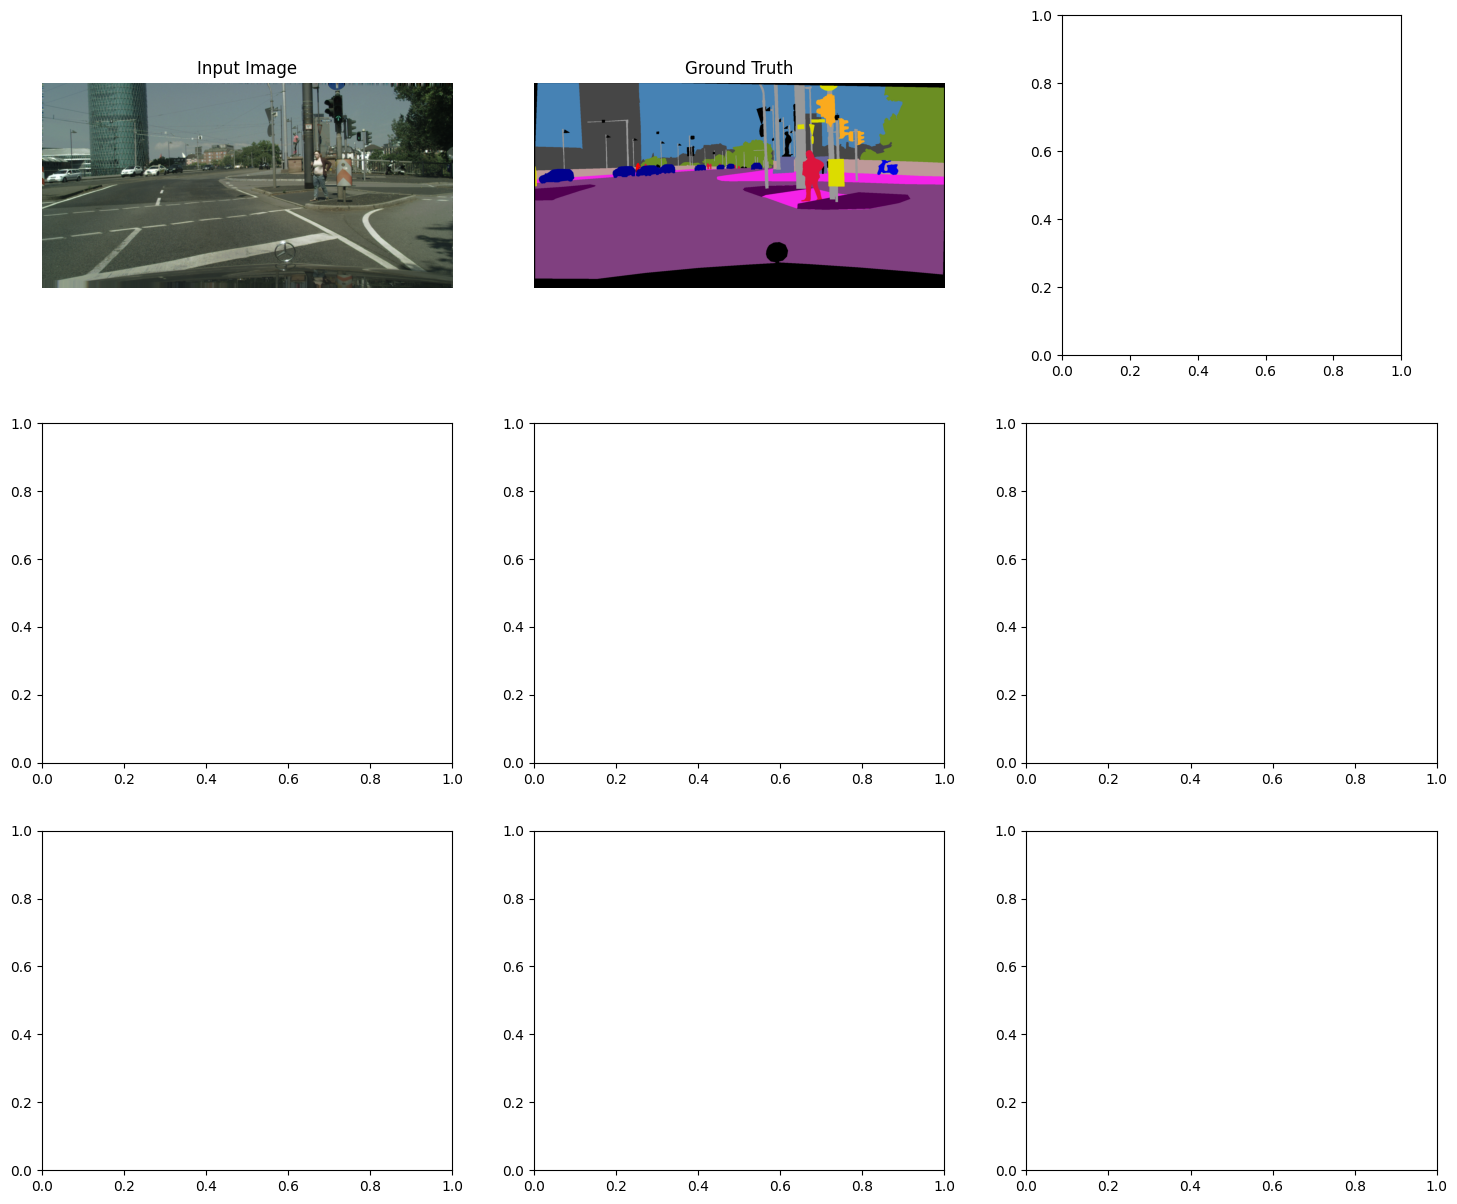

In [60]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets

# get original images without transforms
city_dataset = datasets.Cityscapes('data/', split='val', mode='fine', target_type=['instance', 'color', 'polygon'])

# Plot some images
num_samples = 3
fig, axs = plt.subplots(num_samples, 3, figsize=(18, num_samples * 5))

for i, ((im, (inst, col, poly)), (im2, lb)) in enumerate(zip(city_dataset, ds_val)):
    # get output from the model
    with torch.no_grad():
        output = model(im2[None].cuda(), aux=False)

    # show the input image as a picture
    # Plot input image
    axs[i, 0].imshow(im)
    axs[i, 0].set_title('Input Image')
    axs[i, 0].axis('off')

    # Plot ground truth mask
    axs[i, 1].imshow(col, cmap='viridis')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(output.argmax(0).permute(1,2,0).cpu(), cmap='viridis')
    axs[i, 2].set_title('Prediction')
    axs[i, 2].axis('off')

    if i == num_samples - 1:
        break

plt.tight_layout()
plt.show()

    